This is a Python Notebook for  the Titanic Survival Challenge were the objective will not be only to develop a model, will also be analyze the features and compare a variety of models that can help to solve this challenge.

This notebook will be divided on the next sections:

 1. Intro 
 2. Data cleaning and Transformation
 3. Data Exploration 
 4. Data Modeling with
     4.1 Decision Tree Model
     4.2 Logistic Regression
     4.3 Support Vector Machine.
 5. Comparation
 6. Conclusion

let's take on count that the predictive models might need different preprocessing steps, so I will use different dataframes if needed

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing libary
from sklearn import preprocessing, svm, tree, linear_model, metrics #methods 
#for machine learning tools like preprocessing, models and metrics
from sklearn.model_selection import train_test_split #replace cross_validation method
import matplotlib.pyplot as plt #plotting library
%matplotlib inline

## Intro 
A first impression

In [3]:
#first let's read the data and take a look
titanic_df = pd.read_csv("train.csv") 
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There 12 features including our target feature (Survived), so now check how is builded our dataset

Take this as a note for embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


First, there are three columns with missing data, "Age", "Cabin" and "Embarked". This problem is handled on the next step.
There are five non-numeric columns, we should take a look and then decide how to transform them. Non-numeric data is troublesome so we will handle it on the next step too.

### Cleaning and Transforming Data

Here the first thing is to handle missing data. There are several ways to deal with them, some of them are removing the record, nullify the value (set to null) or impute values. So we must check first the column and how it can affect the target

In [5]:
print("Cabin value count: %d " % titanic_df["Cabin"].count())
print("Age value count: %d" % titanic_df["Age"].count())
print("Embarked value count: %d" % titanic_df["Embarked"].count())

Cabin value count: 204 
Age value count: 714
Embarked value count: 889


Cabin column must be dropped, is amount of missing data is to big that it will affect negatively the model.
For embarked, the value of missing data is very slow, so we can try to imput some value.
Age contains a lot of missing value, but is not so big as Cabin. We could impute the mean age in the missing ages value, but I will use the simplest way: remove the rows (not column) after filling Embarked missing values

In [6]:
titanic_df.drop("Cabin",axis=1,inplace=True)
titanic_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

There is a majority class, which is "S", so we can input "S" for those missing values and proceed to remove the rows with missing values on Age

In [7]:
titanic_df["Embarked"].fillna("S",inplace = True)
titanic_df.dropna(inplace=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Embarked       714 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 66.9+ KB


Now that all the columns have the same number of records, let's transform the non-numeric data and drop columns to improve our analysis. We can make some suppositions based on the columns info. By example, "Name" column have the name of the passengers, and it should be very unique, so it can be 714 different names and that doesn't help to generalize a model. The same goes to "Ticket" column.
"PassengerId" is a unique numerical value, but for our goal (predict survival rate) this information doesn't help. Let's check them.

In [8]:
print("Name value count: %d " % titanic_df["Name"].value_counts().size)
print("Ticket value count: %d " % titanic_df["Ticket"].value_counts().size)
print("PassengerId value count: %d " % titanic_df["PassengerId"].value_counts().size)
print("Sex value count: %d " % titanic_df["Sex"].value_counts().size)
print("Embarked value count: %d " % titanic_df["Embarked"].value_counts().size)

Name value count: 714 
Ticket value count: 542 
PassengerId value count: 714 
Sex value count: 2 
Embarked value count: 3 


As previously said, "Name", "Ticket" and "PassengerID" have very unique values, so we should drop them. For "Sex" and "Embarked", let's transform them into numeric values to improve our analysis. Let's save the true label for later too.

In [9]:
titanic_df.drop(["Name","Ticket","PassengerId"],axis=1, inplace=True)
sex_labels= titanic_df["Sex"].unique()
embarked_labels = titanic_df["Embarked"].unique()

In [10]:
le = preprocessing.LabelEncoder()
le.fit(titanic_df.Sex.values)
titanic_df["Sex"] = le.transform(titanic_df.Sex.values)
sex_labels = titanic_df["Sex"].unique()
sex_labelsE = le.inverse_transform(sex_labels)
le.fit(titanic_df.Embarked.values)
titanic_df["Embarked"] = le.transform(titanic_df.Embarked.values)
embarked_labels = titanic_df["Embarked"].unique()
embarked_labelsE = le.inverse_transform(embarked_labels)

In [11]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Now let's start the Data Exploration

### Data Exploration

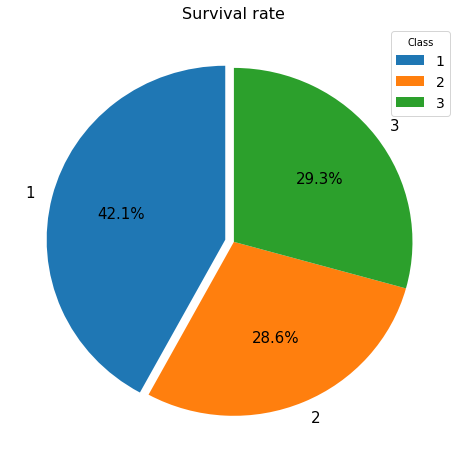

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
titanic_df.groupby('Pclass').sum()['Survived'].plot.pie(
    figsize = (8,8), autopct = '%1.1f%%', startangle = 90, fontsize = 15, explode=(0.05,0,0) )
ax.set_ylabel('')
ax.set_title('Survival rate', fontsize = 16)
ax.legend(labels = titanic_df['Pclass'].unique().sort(), loc = "best", title='Class', fontsize=14)


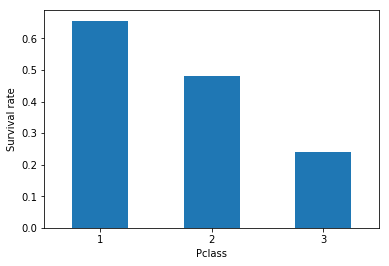

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel("Survival rate")
titanic_df.groupby("Pclass").mean()["Survived"].plot.bar()
ax.set_xticklabels(labels = ax.get_xticklabels(),rotation=0)

We can see that Passenger class is a important feature for forecast survival rate. In average more passenger of the 1° class survived and of the survivors distribution they were a majority class.

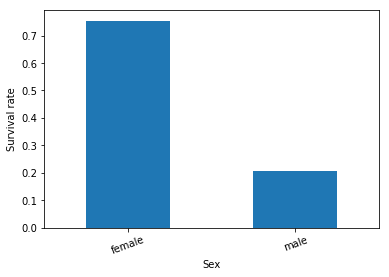

In [14]:
fig = plt.figure()
sorted_labes = [x for (y,x) in sorted(zip(sex_labels,sex_labelsE))]
ax = fig.add_subplot(111)
ax.set_ylabel("Survival rate")
titanic_df.groupby("Sex").mean()["Survived"].plot.bar()
ax.set_xticklabels(labels = sorted_labes,rotation=20)

Female passengers had a greater chance to survive than male passengers (75% vs 20%), let's see plots with the relation between PClass and Sex for male and female for all the classes

In [15]:
index_name=titanic_df.groupby(["Pclass","Sex"]).mean()["Survived"].index.names
index_level=titanic_df.groupby(["Pclass","Sex"]).mean()["Survived"].index.levels
index_ = zip(index_name,index_level)

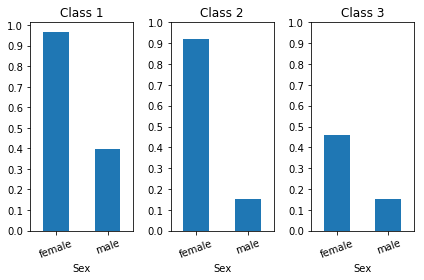

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3)
titanic_df.groupby(["Pclass","Sex"]).mean()["Survived"][1].plot.bar(ax=axes[0] )
titanic_df.groupby(["Pclass","Sex"]).mean()["Survived"][2].plot.bar(ax=axes[1] )
titanic_df.groupby(["Pclass","Sex"]).mean()["Survived"][3].plot.bar(ax=axes[2] )
axes[0].set_title('Class 1')
axes[0].set_xticklabels(labels = sorted_labes,rotation=20)
axes[0].set_yticks(np.arange(0.0,1.1,0.1))
axes[1].set_title('Class 2')
axes[1].set_xticklabels(labels = sorted_labes,rotation=20)
axes[1].set_yticks(np.arange(0.0,1.1,0.1))
axes[2].set_title('Class 3')
axes[2].set_xticklabels(labels = sorted_labes,rotation=20)
axes[2].set_yticks(np.arange(0.0,1.1,0.1))
fig.tight_layout()

Now, let's see about ranges of ages grouped by 10 units

In [17]:
years_range = np.arange(0,90,10)

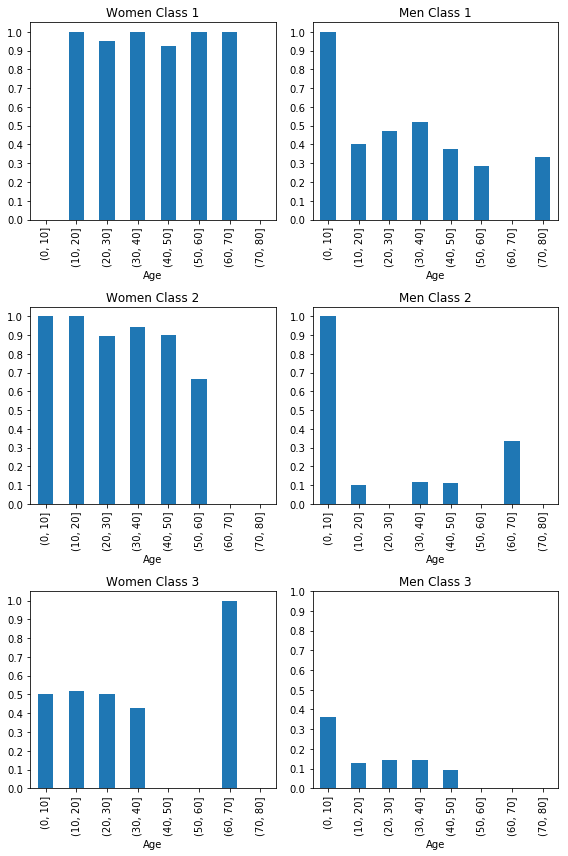

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][1,0].plot.bar(ax=axes[0,0], title = ("Women Class 1") )
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][1,1].plot.bar(ax=axes[0,1], title = ("Men Class 1") )
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][2,0].plot.bar(ax=axes[1,0], title = ("Women Class 2") )
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][2,1].plot.bar(ax=axes[1,1], title = ("Men Class 2") )
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][3,0].plot.bar(ax=axes[2,0], title = ("Women Class 3") )
titanic_df.groupby(by=["Pclass","Sex",pd.cut(titanic_df["Age"],years_range)]).mean()["Survived"][3,1].plot.bar(ax=axes[2,1], title = ("Men Class 3") )
axes[0,0].set_yticks(np.arange(0.0,1.1,0.1))
axes[0,1].set_yticks(np.arange(0.0,1.1,0.1))
axes[1,0].set_yticks(np.arange(0.0,1.1,0.1))
axes[1,1].set_yticks(np.arange(0.0,1.1,0.1))
axes[2,0].set_yticks(np.arange(0.0,1.1,0.1))
axes[2,1].set_yticks(np.arange(0.0,1.1,0.1))
fig.tight_layout()

We can see some paterns like  a female passenger had bigger survival rate in all the clases than male passengers. Also we see that children and older people had the same pattern.
Now let's check the others features

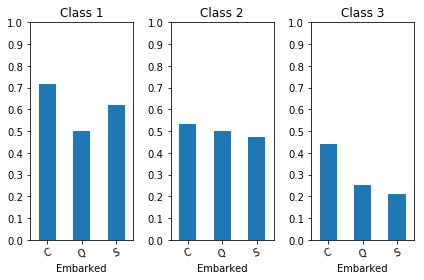

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3)
sorted_labes = [x for (y,x) in sorted(zip(embarked_labels,embarked_labelsE))]
titanic_df.groupby(["Pclass","Embarked"]).mean()["Survived"][1].plot.bar(ax=axes[0] )
titanic_df.groupby(["Pclass","Embarked"]).mean()["Survived"][2].plot.bar(ax=axes[1] )
titanic_df.groupby(["Pclass","Embarked"]).mean()["Survived"][3].plot.bar(ax=axes[2] )
axes[0].set_title('Class 1')
axes[0].set_yticks(np.arange(0.0,1.1,0.1))
axes[0].set_xticklabels(labels = sorted_labes,rotation=20)
axes[1].set_title('Class 2')
axes[1].set_yticks(np.arange(0.0,1.1,0.1))
axes[1].set_xticklabels(labels = sorted_labes,rotation=20)
axes[2].set_title('Class 3')
axes[2].set_yticks(np.arange(0.0,1.1,0.1))
axes[2].set_xticklabels(labels = sorted_labes,rotation=20)
fig.tight_layout()

There is a relation between the embarked port and the survival rate, but is not as bigger like Age and Sex

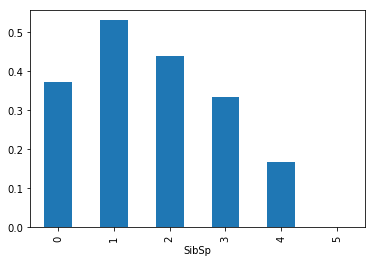

In [20]:
titanic_df.groupby("SibSp").mean()["Survived"].plot.bar()

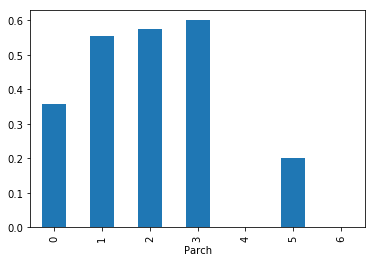

In [21]:
titanic_df.groupby("Parch").mean()["Survived"].plot.bar()

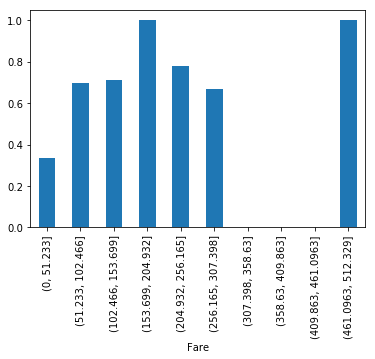

In [22]:
fare_ranges = np.arange(0,max(titanic_df.Fare)+1,max(titanic_df.Fare)/10)
titanic_df.groupby(pd.cut(titanic_df["Fare"],fare_ranges)).mean()["Survived"].plot.bar()

Between SibSp, Parch, Fare there is no important correlation.

Just to be sure, I will run a Random Forest Assesing Feature algorithm (A Feature Selection Algorithm) on the transformed features to asses if my chosed features 

In [27]:
titanic_features = titanic_df.drop("Survived", axis=1)
feat_labels = titanic_df.columns[1:]

In [28]:
from sklearn import ensemble
forest = ensemble.RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(titanic_features,titanic_df["Survived"])
importances = forest.feature_importances_
indices= np.argsort(importances)[::-1]
for f in range(x_training.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[f], importances[indices[f]]))

 1) Pclass                         0.285275
 2) Sex                            0.257921
 3) Age                            0.248526
 4) SibSp                          0.095265
 5) Parch                          0.046965
 6) Fare                           0.038138
 7) Embarked                       0.027911


As the data exploration show, the most influential features are Pclass, Sex and Age; the other ones have a little correlation. Let's check also an option with only the major features

In [42]:
titanic_3features = titanic_features[titanic_features.columns[:3]]
titanic_3features.head()

,Pclass,Sex,Age
0,3,1,22.0
1,1,0,38.0
2,3,0,26.0
3,1,0,35.0
4,3,1,35.0


## Starting with Machine Learning Models

We have to split the Data into two subsets: training and test data.
This subsets will allow us to measure the accuracy and precision of the models to chose the best one to use

In [25]:
from sklearn import model_selection
from sklearn import preprocessing, metrics

In [53]:
#let's standarize the feature value to improve the prediction
sc = preprocessing.StandardScaler()
#------ for all features
sc.fit(titanic_features)
titanic_features_std = sc.transform(titanic_features)
#------ only 3 features
sc.fit(titanic_3features)
titanic_3features_std = sc.transform(titanic_3features)

In [55]:
#let's split the data into training and test subsets
#-------- for all features
x_train, x_test, y_train, y_test =  model_selection.train_test_split(
    titanic_features_std, titanic_df.Survived, test_size = 0.3, random_state = 0)
#-------- only 3 features
x_3f_train, x_3f_test, y_3f_train, y_3f_test = model_selection.train_test_split(
    titanic_3features_std, titanic_df.Survived, test_size = 0.3, random_state = 0)

### Decision Trees

Decision Trees are of the most intuitive algorithms, so I will start with it.
Remember, the first thing is to train the model and test it with the training data.

In [60]:
from sklearn.tree import DecisionTreeClassifier
cm_tree = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)

#### All features

In [61]:
cm_tree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [62]:
y_predict = cm_tree.predict(x_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_test,y_predict))
print("The precision is: %2f" % metrics.precision_score(y_test,y_predict))

The accuracy is: 0.809302
The precision is: 0.802469


#### 3 major features

In [63]:
cm_tree.fit(x_3f_train,y_3f_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [64]:
y_3f_predict = cm_tree.predict(x_3f_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_3f_test,y_3f_predict))
print("The precision is: %2f" % metrics.precision_score(y_3f_test,y_3f_predict))

The accuracy is: 0.795349
The precision is: 0.925926


### Logistic Regression

Of the most classic ML algoritmhs for Classification Task

In [65]:
from sklearn.linear_model import LogisticRegression
cm_lr = LogisticRegression(C=1000.0, random_state = 0)

#### all Features

In [69]:
cm_lr.fit(x_train,y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [68]:
y_predict = cm_lr.predict(x_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_test,y_predict))
print("The precision is: %2f" % metrics.precision_score(y_test,y_predict))

The accuracy is: 0.818605
The precision is: 0.800000


#### Only 3 features

In [70]:
cm_lr.fit(x_3f_train,y_3f_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
y_predict = cm_lr.predict(x_3f_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_test,y_predict))
print("The precision is: %2f" % metrics.precision_score(y_test,y_predict))

The accuracy is: 0.832558
The precision is: 0.821429


### SVM - Support Vector Classifier

This Algorithm is very popular in the Classification Task due the performance and the heuristic approach (the algorithm doesn't depend of random values)

In [92]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 10.0, random_state = 0)

#### All Features

In [93]:
svm.fit(x_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
y_predict = svm.predict(x_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_test,y_predict))
print("The precision is: %2f" % metrics.precision_score(y_test,y_predict))

The accuracy is: 0.790698
The precision is: 0.784810


#### Only 3 Features

In [95]:
svm.fit(x_3f_train, y_3f_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
y_predict = svm.predict(x_3f_test)
print("The accuracy is: %2f" % metrics.accuracy_score(y_test,y_predict))
print("The precision is: %2f" % metrics.precision_score(y_test,y_predict))

The accuracy is: 0.790698
The precision is: 0.784810


## Conclusion

The Data Exploration and Cleaning phases wheren't to deep, but it gave us the enough information to know which columns had to be dropped before creating the ML model and of the remainig features which where the Most Influential ones. 
On the ML phase the three models are from the simplest one to learn and had a good performance. I can't say that one model is better than other because each one had good points and bad point in different dataset types, and for this one they had very low differneces. Altough, I will use the Logistic Regression to make my submit for this dataset

## Submission test

In [ ]:
test_data = pd.read_csv("test")